# Marginal Learning in Discrete Markov Networks

In this notebook, we show an example for learning the parameters (potentials) of a Factor Graph or Markov Network given the data and its corresponding marginals.

In the examples, we will generate some data from given models and perform out of clique inference for certain queries.

## Modeling who wins a Football game
Model who wins a football game just based off who won each game of the season.

In [12]:
from pgmpy.models import FactorGraph, JunctionTree
from pgmpy.factors.discrete import DiscreteFactor
import numpy as np
import networkx as nx
import pandas as pd
import itertools
from pgmpy.estimators import MirrorDescentEstimator
from pgmpy.inference.ExactInference import BeliefPropagation
from pgmpy.factors import FactorDict
from matplotlib import pyplot as plt

### Step 1: Load the `games` data and form a `FactorGraph`
`games` has the results of the 2023-2024 NFL season including the playoffs, but excluding the Super Bowl.

In [2]:
games = pd.read_csv("data/games.csv")
# Define a "win" to include ties for the home team.
games["homeWin"] = (games.homeFinalScore >= games.visitorFinalScore).map(
    lambda x: "win" if x else "loss"
)
TEAMS = sorted(set(games.homeTeamAbbr).union(set(games.visitorTeamAbbr)))
COLUMNS = ["homeTeamAbbr", "visitorTeamAbbr", "homeWin"]
df = games[COLUMNS]
df.head()

,homeTeamAbbr,visitorTeamAbbr,homeWin
0,NYG,DAL,loss
1,NYJ,BUF,win
2,NE,PHI,loss
3,BAL,HOU,win
4,MIN,TB,loss


In [4]:
G = FactorGraph()
nodes = COLUMNS
# Map of variables to all possible states.
state_names = {
    "homeTeamAbbr": TEAMS,
    "visitorTeamAbbr": TEAMS,
    "homeWin": ["loss", "win"],
}
cardinalities = {"homeTeamAbbr": 32, "visitorTeamAbbr": 32, "homeWin": 2}
# Form factors with all possible combinations of columns. Initialize each
# factor with zeros.
factors = [
    DiscreteFactor(
        variables=i,
        cardinality=[cardinalities[j] for j in i],
        values=np.zeros(tuple(cardinalities[j] for j in i)),
        state_names=state_names,
    )
    # Model one-way, two-way, & three-way marginals.
    for i in list(
        itertools.chain.from_iterable(
            [list(itertools.combinations(COLUMNS, i)) for i in range(1, 4)]
        )
    )
]
G.add_nodes_from(nodes=nodes)
G.add_factors(*factors)
G.add_edges_from(
    [(node, factor) for node in nodes for factor in factors if node in factor.scope()]
)
G.check_model()

True

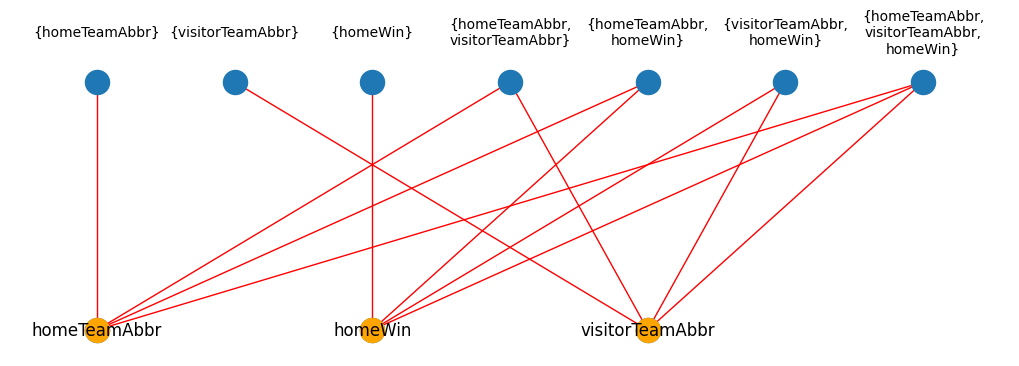

In [13]:
# Print the structure of the Graph to verify its correctness.
plt.figure(figsize=(10, 3))
top = {team: (i * 2, 0) for i, team in enumerate(sorted(nodes))}
bottom = {factor: (i, 1) for i, factor in enumerate(factors)}
# Draw all the variables & factors with their edges.
nx.draw(
    G,
    pos={**top, **bottom},
    edge_color="red",
)
# Draw text labels for the factors above their nodes in the graph.
label_dict = {factor: "{" + ",\n".join(factor.scope()) + "}" for factor in G.factors}
for node, (x, y) in bottom.items():
    plt.text(x, y * 1.2, label_dict[node], fontsize=10, ha="center", va="center")
# Re-draw the variables but with labels this time and colored orange.
nx.draw(
    G.subgraph(nodes),
    node_color="orange",
    pos={**top},
    with_labels=True,
)
plt.show()

### Step 2: Define a model using `MirrorDescentEstimator`

In [14]:
# Initialize model
estimator = MirrorDescentEstimator(model=G, data=games)
marginals = [tuple(i.scope()) for i in G.factors]
observed_factor_dict = FactorDict.from_dataframe(df=games, marginals=marginals)

### Step 3: Learn the marginals 

In [15]:
%%time
_ = estimator.estimate(
    marginals=marginals, metric="L2", iterations=2000
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 2.79 s, sys: 380 ms, total: 3.17 s
Wall time: 3.11 s


### Step 4: View the true marginals against estimated marginals

In [16]:
tree = estimator.belief_propagation.junction_tree
modeled_factor = tree.factors[0]

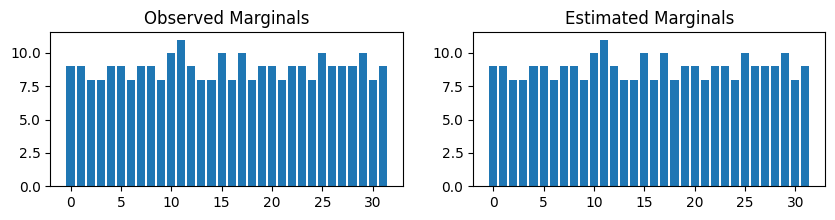

In [17]:
# Compare a larger clique against the true marginals.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
visitorTeamAbbr_marginal = observed_factor_dict[("visitorTeamAbbr",)]
total_states = np.prod(visitorTeamAbbr_marginal.cardinality)
axes[0].bar(
    range(total_states),
    visitorTeamAbbr_marginal.values.flatten(),
)
axes[0].set_title("Observed Marginals")
axes[1].bar(
    range(total_states),
    modeled_factor.marginalize(
        ["homeTeamAbbr", "homeWin"], inplace=False
    ).values.flatten(),
)
axes[1].set_title("Estimated Marginals")
plt.show()

# Modeling the home & visitor scores
Now, we add back in the score for the home and visitor teams.

### Step 1: Make a new df from `games` with the score columns

In [18]:
MAX_SCORE = max(set(games.homeFinalScore).union(games.visitorFinalScore))
COLUMNS_2 = ["homeTeamAbbr", "visitorTeamAbbr", "homeFinalScore", "visitorFinalScore"]
df2 = games[COLUMNS_2]
df2.head()

,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,NYG,DAL,0,40
1,NYJ,BUF,22,16
2,NE,PHI,20,25
3,BAL,HOU,25,9
4,MIN,TB,17,20


In [19]:
# This time, more marginals are possible.
marginals_2 = list(
    itertools.chain.from_iterable(
        [list(itertools.combinations(COLUMNS_2, i)) for i in range(1, 5)]
    )
)
marginals_2

[('homeTeamAbbr',),
 ('visitorTeamAbbr',),
 ('homeFinalScore',),
 ('visitorFinalScore',),
 ('homeTeamAbbr', 'visitorTeamAbbr'),
 ('homeTeamAbbr', 'homeFinalScore'),
 ('homeTeamAbbr', 'visitorFinalScore'),
 ('visitorTeamAbbr', 'homeFinalScore'),
 ('visitorTeamAbbr', 'visitorFinalScore'),
 ('homeFinalScore', 'visitorFinalScore'),
 ('homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore'),
 ('homeTeamAbbr', 'visitorTeamAbbr', 'visitorFinalScore'),
 ('homeTeamAbbr', 'homeFinalScore', 'visitorFinalScore'),
 ('visitorTeamAbbr', 'homeFinalScore', 'visitorFinalScore'),
 ('homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore', 'visitorFinalScore')]

### Step 2: Junction Tree creation directly from the data's marginals

In [22]:
# Instead of creating our graph from every possible combination, we can build
# directly from the dataframe, and then setting each factor equal to 0.0.
G_2 = JunctionTree()
nodes = COLUMNS_2
observed_factor_dict = FactorDict.from_dataframe(
    games,
    marginals=marginals_2,
)
factors_2 = observed_factor_dict = [
    i.identity_factor() for i in observed_factor_dict.values()
]
G_2.add_node(node=COLUMNS_2)
G_2.add_factors(factors_2[-1])
G_2.check_model()

True

In [23]:
# We have a single clique, including all of the dataframe's columns.
print(G_2.nodes)
print(G_2.factors)

[('homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore', 'visitorFinalScore')]
[<DiscreteFactor representing phi(homeTeamAbbr:32, visitorTeamAbbr:32, homeFinalScore:45, visitorFinalScore:40) at 0x2ac6d5120>]


### Step 3: Use `MirrorDescentEstimator` to fit a `JunctionTree` to the data's marginals

In [24]:
# Initialize the new estimation.
estimator_2 = MirrorDescentEstimator(model=G_2, data=games)

In [25]:
%%time
_ = estimator_2.estimate(
    marginals=marginals_2, metric="L2", iterations=600
)

  0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 1min 22s, sys: 1min 20s, total: 2min 42s
Wall time: 2min 45s


In [26]:
tree_2 = estimator_2.belief_propagation.junction_tree
modeled_factor_2 = tree_2.factors[0]

### Step 4: Perform a query on a future game

In [27]:
# Inference for a hypothetical game.
sf_kc = BeliefPropagation(tree_2).query(
    variables=["homeFinalScore", "visitorFinalScore"],
    evidence={"homeTeamAbbr": "KC", "visitorTeamAbbr": "SF"},
    joint=True,
    show_progress=True,
)
kc_sf = BeliefPropagation(tree_2).query(
    variables=["homeFinalScore", "visitorFinalScore"],
    evidence={"homeTeamAbbr": "SF", "visitorTeamAbbr": "KC"},
    joint=True,
    show_progress=True,
)

In [28]:
assert isinstance(sf_kc, DiscreteFactor)
sf_kc_sample = sf_kc.sample(1_000_000)
assert isinstance(kc_sf, DiscreteFactor)
kc_sf_sample = kc_sf.sample(1_000_000)

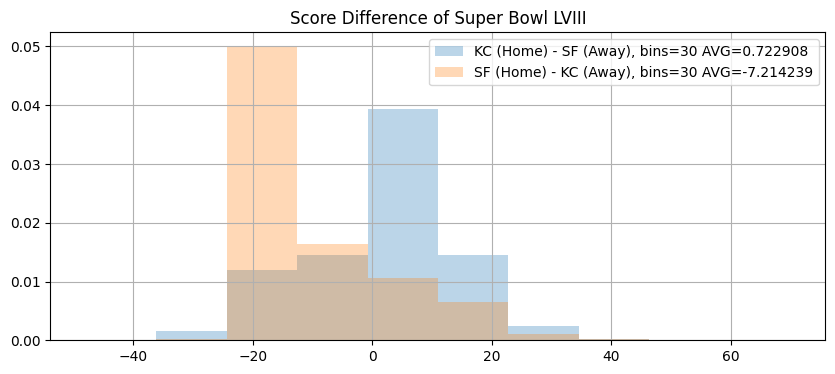

In [29]:
plt.figure(figsize=(10, 4))
sf_kc_diff = sf_kc_sample.homeFinalScore - sf_kc_sample.visitorFinalScore
sf_kc_diff.hist(
    alpha=0.3,
    label=f"KC (Home) - SF (Away), bins=30 AVG={sf_kc_diff.mean()}",
    density=True,
)
kc_sf_diff = kc_sf_sample.homeFinalScore - kc_sf_sample.visitorFinalScore
kc_sf_diff.hist(
    alpha=0.3,
    label=f"SF (Home) - KC (Away), bins=30 AVG={kc_sf_diff.mean()}",
    density=True,
)
plt.title("Score Difference of Super Bowl LVIII")
plt.legend()
plt.show()